In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import *
slim = tf.contrib.slim
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from mnist_model import generator,discriminator
import utils
l = tf.layers

/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
"""
idea:
-add ema


conclusion:
-ambient reg on GAN samples is more powerful than unlabeled ambient reg (ie:GAN is a regularizer itself)
-0.001 *consistency_gan_loss

"""

In [87]:
def get_getter(ema):
    def ema_getter(getter, name, *args, **kwargs):
        var = getter(name, *args, **kwargs)
        ema_var = ema.average(var)
        return ema_var if ema_var else var
    return ema_getter

## Hyperparam

In [2]:
params = dict(
    batch_size = 100,
    seed = 1234,
    z_dim = 100,
    x_dim = 784,
    reg_w = 0.,
    lr = 1e-4,
    logdir = 'gan_mnist/',
    name_model = 'model_latent100_fc'
)
rng = np.random.RandomState(params['seed'])  # seed labels

## Data creation (unl)

In [20]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
trainx = np.vstack([mnist.train.images,mnist.validation.images])
trainy = np.hstack([mnist.train.labels,mnist.validation.labels])
testx = mnist.test.images
testy = mnist.test.labels
trainx = np.reshape(trainx,[-1,28,28,1])
testx = np.reshape(testx,[-1,28,28,1])
trainx_unl = trainx.copy()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Build model

In [5]:
tf.reset_default_graph()

In [6]:
unl_dataset = tf.data.Dataset.from_tensor_slices(trainx_unl)
unl_dataset = unl_dataset.shuffle(10000).repeat().batch(params['batch_size'])
iterator_unl = unl_dataset.make_one_shot_iterator()
next_unl = iterator_unl.get_next()

is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
data = tf.cast(next_unl,tf.float32)
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])

samples = generator(noise,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
real_score = discriminator(data,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
fake_score = discriminator(samples,is_training=is_training_pl,reuse=tf.AUTO_REUSE)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator") 

loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.ones_like(fake_score)))
loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score,labels=tf.ones_like(fake_score)))+\
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.zeros_like(fake_score)))

optimizer_dis = tf.train.AdamOptimizer(learning_rate=params['lr'], beta1=0.5, name='dis_optimizer')
optimizer_gen = tf.train.AdamOptimizer(learning_rate=params['lr'], beta1=0.5, name='gen_optimizer')

update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
update_ops_dis = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')

with tf.control_dependencies(update_ops_gen): # attached op for moving average batch norm
    traing = optimizer_gen.minimize(loss_g,var_list=gen_vars)
with tf.control_dependencies(update_ops_dis):
    traind = optimizer_dis.minimize(loss_d,var_list=disc_vars)

Tensor("discriminator/layer_3/leaky_relu/sub:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("discriminator_1/layer_3/leaky_relu/sub:0", shape=(100, 4, 4, 512), dtype=float32)


In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='my_scope')
saver = tf.train.Saver()

In [8]:
if tf.train.latest_checkpoint(os.path.join('./gan_mnist/')) is not None:
    path = saver.restore(sess, tf.train.latest_checkpoint(os.path.join('./gan_mnist/')))
else:
    print('no model found')

INFO:tensorflow:Restoring parameters from ./gan_mnist/model_latent100_fc


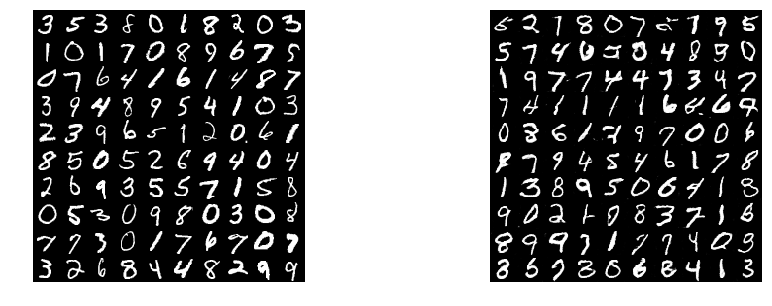

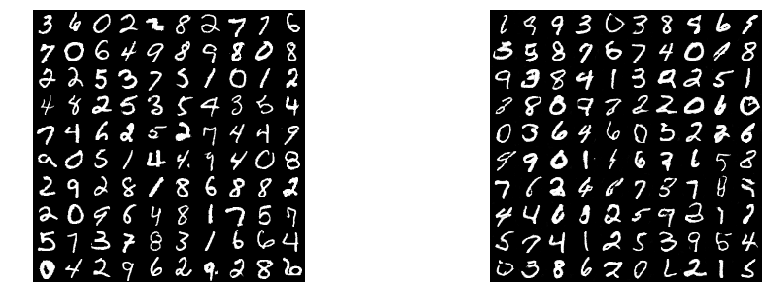

KeyboardInterrupt: 

In [9]:
fs = []
frames = []
np_samples = []
n_batches_viz = 1
viz_every = 500
lsd=[]
lsg=[]
for i in tqdm(range(10001)):
#     f, _= sess.run([[loss], train_op],{is_training_pl:True})
    ld,_=sess.run([loss_d,traind],{is_training_pl:True})
    lg,_=sess.run([loss_g, traing],{is_training_pl:True})
    lsd.append(ld); lsg.append(lg);

    if (i) % viz_every == 0:
        xx, yy = sess.run([data,samples],{is_training_pl:True})
#         print('iter nr : ',gstep)
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        show_digits(xx[:100])
        plt.subplot(122)
        show_digits(yy[:100])
        plt.show()


In [11]:
if not os.path.exists(params['logdir']):
    os.makedirs(params['logdir'])
saver.save(sess, os.path.join('./saved_models/',params['logdir'],params['name_model']))


ValueError: Parent directory of ./saved_models/gan_mnist/model_latent100_fc doesn't exist, can't save.

In [157]:
saver.save(sess, './efficient_model_saved/')


'./efficient_model_saved/'

In [84]:
mkdir 

bac_a_sable.ipynb                    mnist_model.py
experiments_regularizations_1.ipynb  mnist_neural_net.py
experiments_regularizations_2.ipynb  mnsit-net.ipynb
experiments_regularizations_3.ipynb  nn.py
gan_mnist/                           __pycache__/
latent_viz.ipynb                     README.md
MNIST_data/                          regularized-neural-net.ipynb
mnist_experiments-Copy1.ipynb        ssl_experiments.ipynb
mnist_experiments.ipynb              utils.py


## CNN

In [47]:
params_dnn = dict(
    epsilon = .1,
    gamma = 0.1, #2.
    delta = 0.01,
    batch = 50,
    mc = 200,
    lr=1e-4,
    beta1 = 0.9,
    epoch = 200,
    l2_w = 0.1,
    labeled = 10
)
rng = np.random.RandomState(params['seed'])  # seed labels

(100, 28, 28, 1) (10000, 28, 28, 1)


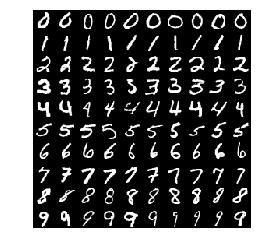

In [21]:
trainx_unl = trainx.copy()
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:params_dnn['labeled']])
    tys.append(trainy[trainy == j][:params_dnn['labeled']])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys
nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']
print(trainx.shape,testx.shape)
show_digits(trainx[:])
plt.show()

## defining model

In [22]:
def lenet(x,training_pl,getter=None):
    with tf.variable_scope("classifier", reuse=tf.AUTO_REUSE, custom_getter=getter):
        x = tf.reshape(x,[-1,28,28,1])
        x = tf.layers.conv2d(x,32,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.layers.conv2d(x,64,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.reshape(x, [-1, 7 * 7 * 64])
        x = tf.layers.dense(x,1024,activation=tf.nn.relu)
        x = tf.layers.dropout(x,rate=0.4,training=training_pl)
        x = tf.layers.dense(x,10)
        return x
    
soft = lambda x: 1/(1+tf.exp(-x))    

In [23]:
inp = tf.placeholder(tf.float32, [params_dnn['batch'], 28,28,1])
lbl = tf.placeholder(tf.int64, [params_dnn['batch']])
training_cnn  = tf.placeholder(tf.bool,[])

logits = lenet(inp,training_cnn)
xloss = tf.losses.sparse_softmax_cross_entropy(logits=logits,labels=lbl)

In [137]:
# samp_logits1 = lenet(samples,training_cnn)
# p1 = tf.random_normal([params['batch_size'],28,28,1],stddev=0.2) 
# samp_logits2 = lenet(samples + p1,training_cnn)
# p3 = tf.random_normal([params['batch_size'],28,28,1],stddev=0.2) 
# samp_logits3 = lenet(samples + p3,training_cnn)


# unl = tf.placeholder(tf.float32, [params['batch_size'], 28,28,1])
# unl_logits1 = lenet(unl,training_cnn)
# p2 = tf.random_normal([params['batch_size'],28,28,1],stddev=0.2) 
# unl_logits2 = lenet(unl+p2,training_cnn)

# consistency_gan = tf.reduce_sum(tf.sqrt(tf.square(samp_logits1-samp_logits2)+1e-8),axis=1)
# consistency_gan_loss = tf.reduce_mean(consistency_gan)

# ambient_gan = tf.reduce_sum(tf.sqrt(tf.square(samp_logits3-samp_logits2)+1e-8),axis=1)
# ambient_gan_loss = tf.reduce_mean(ambient_gan)

# consistency_unl = tf.reduce_sum(tf.sqrt(tf.square(unl_logits1-unl_logits2)+1e-8),axis=1)
# consistency_unl_loss = tf.reduce_mean(consistency_unl)

# kl_gan = kl_divergence_with_logit(samp_logits1,samp_logits2)
# kl_unl = kl_divergence_with_logit(unl_logits1,unl_logits2)


############ manifold loss ##########
z1 = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
pert_n = tf.nn.l2_normalize(tf.random_normal(shape=[params['batch_size'],params['z_dim']]),dim=[1])
z1_pert = z1 + 2. * pert_n
pz = tf.random_normal([params['batch_size'],28,28,1],stddev=0.2) 

samp_z1 = generator(z1,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_z2 = generator(z1_pert,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
logits_z1= lenet(samp_z1,training_cnn)
logits_z2 = lenet(samp_z2,training_cnn)

manifold = tf.reduce_sum(tf.sqrt(tf.square(logits_z1-logits_z2)+1e-8),axis=1)
manifold_loss = tf.reduce_mean(consistency_unl)


loss = xloss + 0.001 * manifold_loss
#+ .0 * consistency_gan_loss + 0. * consistency_unl_loss # + 1. * kl_unl 
#0.001 *consistency_gan_loss

In [156]:
xx,yy = sess.run([samp_z1,samp_z2],{is_training_pl:False})

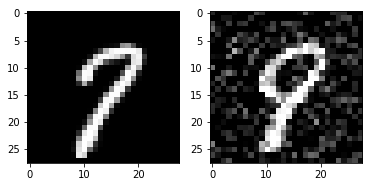

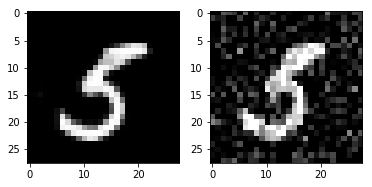

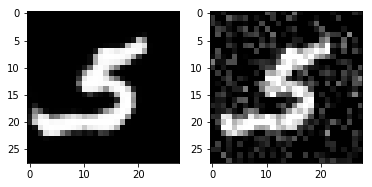

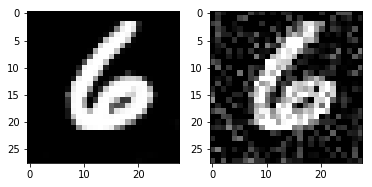

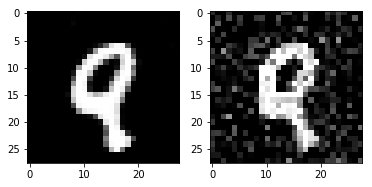

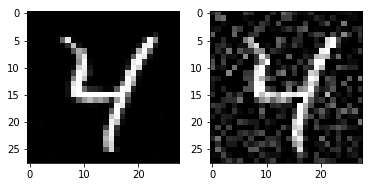

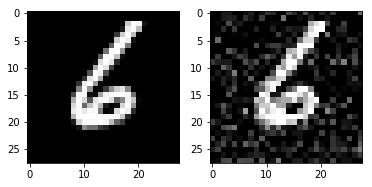

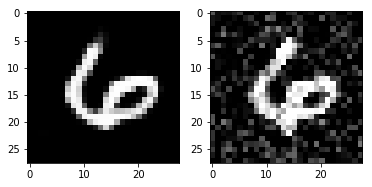

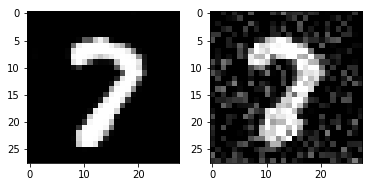

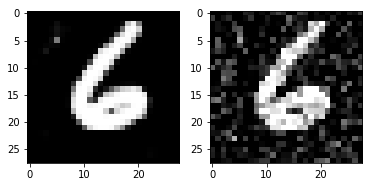

In [134]:
for idx in range(10):
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(xx[idx]),cmap='gray',vmin=0,vmax=1)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(yy[idx]),cmap='gray',vmin=0,vmax=1)
    plt.show()

In [138]:
with tf.variable_scope("classifier",reuse=tf.AUTO_REUSE):
    optimizer = tf.train.AdamOptimizer(learning_rate=params_dnn['lr'])
    train_op = optimizer.minimize(loss,var_list=tf.trainable_variables(scope='classifier'))

correct_prediction = tf.equal(tf.argmax(logits,1),lbl)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#init
var = tf.global_variables(scope='classifier')
init_op = tf.variables_initializer(var_list=var)

In [121]:
ema = tf.train.ExponentialMovingAverage(decay=0.9999)
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "classifier")
maintain_averages_op = ema.apply(dvars)
with tf.control_dependencies([train_op]):
    train_dis_op = tf.group(maintain_averages_op)
logits_ema = lenet(inp, training_cnn, getter=get_getter(ema))

ValueError: Variable classifier/conv2d/kernel/ExponentialMovingAverage/ already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-89-2995fcd65670>", line 3, in <module>
    maintain_averages_op = ema.apply(dvars)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):


## cnn training

In [139]:
sess.run(init_op)
con_loss = []
test_array = []
length_epoch = 1000
nr_batch_train = length_epoch // params_dnn['batch']
print(nr_batch_train)
print("epoch length:", length_epoch,", batch size:", params_dnn['batch'], 
      ", nr_batch_train:",nr_batch_train, ", mc size:", params['batch_size'],",total grad iter:",length_epoch * params_dnn['epoch'])
for epoch in tqdm(range(params_dnn['epoch'])):
    train_acc=train_loss=test_acc=0
    trainx = [];trainy = []
    for t in range(int(np.ceil(length_epoch / float(txs.shape[0])))):  # same size lbl and unlb
        inds = np.random.permutation(txs.shape[0])
        trainx.append(txs[inds])
        trainy.append(tys[inds])
    trainx = np.concatenate(trainx, axis=0)
    trainy = np.concatenate(trainy, axis=0)
    trainx_unl = trainx_unl[rng.permutation(trainx_unl.shape[0])]  # shuffling unl dataset   
#     print(trainx.shape)
    for t in range(nr_batch_train):
#         print(t)
        ran_from = t * params_dnn['batch']
        ran_to = (t + 1) * params_dnn['batch']
        ran_from_mc = t * params['batch_size']
        ran_to_mc = (t + 1) * params['batch_size']
#         print(ran_from,ran_to)

        xl,_,acc,con = sess.run([xloss,train_op,accuracy, manifold_loss],feed_dict={inp: trainx[ran_from:ran_to],
                                                                 lbl: trainy[ran_from:ran_to],
                                                                 unl: trainx_unl[ran_from_mc:ran_to_mc],
                                                                 training_cnn:True,
                                                                 is_training_pl:False})
        train_acc += acc; train_loss += xl
        con_loss.append(con)
    train_acc /= nr_batch_train; train_loss /= nr_batch_train
    
    if epoch % 1 == 0:
        for t in range(nr_batch_test):
            ran_from = t * params_dnn['batch']
            ran_to = (t + 1) * params_dnn['batch']
            xl,acc = sess.run([xloss,accuracy],feed_dict={inp: testx[ran_from:ran_to],
                                                                     lbl: testy[ran_from:ran_to],
                                                                     training_cnn:False})
            test_acc += acc; 
        test_acc /= nr_batch_test; test_array.append(test_acc);
        print("Epoch: {}, xloss: {:.5f}, training acc: {:.2f}%, test acc: {:.2f}%".format(epoch, train_loss, train_acc * 100,test_acc*100))


20
epoch length: 1000 , batch size: 50 , nr_batch_train: 20 , mc size: 100 ,total grad iter: 200000


Epoch: 0, xloss: 2.05194, training acc: 58.90%, test acc: 61.34%
Epoch: 1, xloss: 1.39079, training acc: 82.20%, test acc: 64.60%
Epoch: 2, xloss: 0.72904, training acc: 86.30%, test acc: 67.78%
Epoch: 3, xloss: 0.38876, training acc: 91.30%, test acc: 73.88%
Epoch: 4, xloss: 0.22297, training acc: 96.00%, test acc: 76.56%
Epoch: 5, xloss: 0.14358, training acc: 98.00%, test acc: 77.70%
Epoch: 6, xloss: 0.09440, training acc: 99.40%, test acc: 78.58%
Epoch: 7, xloss: 0.06343, training acc: 99.70%, test acc: 77.54%
Epoch: 8, xloss: 0.04709, training acc: 99.80%, test acc: 78.14%
Epoch: 9, xloss: 0.03413, training acc: 99.90%, test acc: 78.44%
Epoch: 10, xloss: 0.02361, training acc: 100.00%, test acc: 79.20%
Epoch: 11, xloss: 0.02091, training acc: 100.00%, test acc: 79.36%
Epoch: 12, xloss: 0.01612, training acc: 100.00%, test acc: 79.64%
Epoch: 13, xloss: 0.01313, training acc: 100.00%, test acc: 79.30%
Epoch: 14, xloss: 0.01216, training acc: 100.00%, test acc: 79.34%
Epoch: 15, xlos

Epoch: 123, xloss: 0.00079, training acc: 100.00%, test acc: 81.16%
Epoch: 124, xloss: 0.00085, training acc: 100.00%, test acc: 81.32%
Epoch: 125, xloss: 0.00081, training acc: 100.00%, test acc: 81.14%
Epoch: 126, xloss: 0.00081, training acc: 100.00%, test acc: 81.24%
Epoch: 127, xloss: 0.00078, training acc: 100.00%, test acc: 81.32%
Epoch: 128, xloss: 0.00079, training acc: 100.00%, test acc: 81.30%
Epoch: 129, xloss: 0.00081, training acc: 100.00%, test acc: 81.38%
Epoch: 130, xloss: 0.00078, training acc: 100.00%, test acc: 81.26%
Epoch: 131, xloss: 0.00080, training acc: 100.00%, test acc: 81.14%
Epoch: 132, xloss: 0.00081, training acc: 100.00%, test acc: 81.46%
Epoch: 133, xloss: 0.00079, training acc: 100.00%, test acc: 81.34%
Epoch: 134, xloss: 0.00077, training acc: 100.00%, test acc: 81.28%
Epoch: 135, xloss: 0.00076, training acc: 100.00%, test acc: 81.28%
Epoch: 136, xloss: 0.00077, training acc: 100.00%, test acc: 81.62%
Epoch: 137, xloss: 0.00078, training acc: 100.00

In [163]:
t

200

In [140]:
# acc_kl_gan = test_array
# acc_vanilla = test_array
# acc_con_unl = test_array
# acc_con_unl_200 = test_array
# unl200 = gan200
# gan200 = test_array
# gan_unl = test_array
# manifold_ambient = test_array
# mani = test_array

In [152]:
xx,yy=sess.run([samples,samples+p1],{is_training_pl:False})

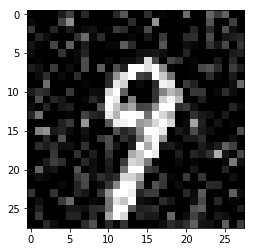

In [153]:
plt.imshow(np.squeeze(yy[2]),cmap='gray',vmin=0,vmax=1)

(0.77, 0.82)

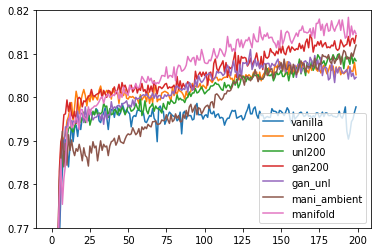

In [141]:
# plt.plot(acc_kl_gan)
plt.plot(acc_vanilla)
plt.plot(acc_con_unl_200)
plt.plot(unl200)
plt.plot(gan200)
plt.plot(gan_unl)
plt.plot(manifold_ambient)
plt.plot(manifold)
plt.legend(['vanilla','unl200','unl200','gan200','gan_unl','mani_ambient','manifold'])
plt.ylim([0.77,0.82])

(0.77, 0.82)

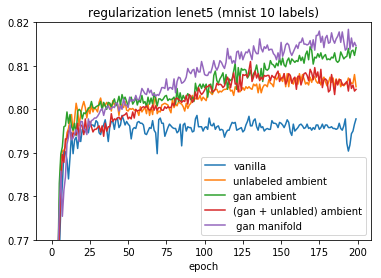

In [148]:
# plt.plot(acc_kl_gan)
plt.plot(acc_vanilla)
plt.plot(acc_con_unl_200)
# plt.plot(unl200)
plt.plot(gan200)
plt.plot(gan_unl)
# plt.plot(manifold_ambient)
plt.plot(manifold)
plt.legend(['vanilla','unlabeled ambient','gan ambient','(gan + unlabled) ambient',' gan manifold'])
plt.title('regularization lenet5 (mnist 10 labels)')
plt.xlabel('epoch')
plt.ylim([0.77,0.82])

In [ ]:
sess.run()

In [155]:
sess.run(manifold,{training_cnn:False,is_training_pl:False})

TypeError: Fetch argument 0.6134000024199486 has invalid type <class 'numpy.float64'>, must be a string or Tensor. (Can not convert a float64 into a Tensor or Operation.)

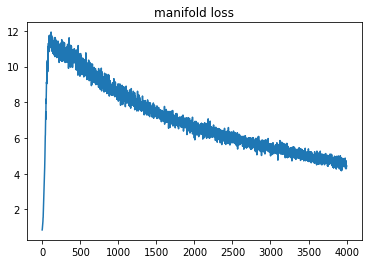

In [150]:
plt.plot(con_loss)
plt.title('manifold loss')
plt.show()

In [178]:
nr_batch_train

6000

In [167]:
np.asarray([7, 8, 2, 6, 4, 5, 1, 3, 0, 9])

array([7, 8, 2, 6, 4, 5, 1, 3, 0, 9])